<h1 style="text-align:center;font-size:50px">Sentiment Analysis - IMDB reviews</h1>

<br>
<h2>Problem statement</h2>

Given reviews of movies classify whether the review is positive or negative.

<h2>Data</h2>

50,000 movie reviews contained in IMDB dataset

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Loading dataset
df = pd.read_csv("IMDB_reviews.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# Viewing dimensions of dataset
df.shape

(50000, 2)

In [4]:
# Checking for NaNs
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [5]:
# Checking for data imbalance
df["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

**We find that the dataset is perfectly balanced.**

# 1) Text pre-processing

<br>
<h3>Steps involved :-</h3>

- **Case Folding :-** Converting all characters to lowercase.
- **Removing numbers**
- **Remove HTML tags**
- **Remove URLs**
- **Expand contractions :-** Expanding words like I'm to I am.
- **Remove punctuations**
- **Rectify incorrect spellings :-** For this dataset, performing this step almost makes no difference in accuracy. However, it does take huge amt. of time.
- **Lemmatization**

In [6]:
# Libraries & classes for text-preprocessing
import re
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
from contractions import CONTRACTION_MAP

html_pattern = re.compile('<.*?>')
url_pattern = re.compile(r'https?://\S+|www\.\S+')
PUNCTS_TO_REMOVE = string.punctuation
spell = SpellChecker()
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
STOPWORDS = stopwords.words("english")
STOPWORDS.remove("no")
STOPWORDS.remove("not")

In [7]:
# Utility functions for text pre-processing

def text_cleaner_pipeline(text):
    # Case folding
    text = str(text).lower()
    
    # Remove numbers
    text = remove_nos(text)
    
    # Remove HTML tags
    text = remove_HTML_tags(text)
    
    # Remove URLs
    text = remove_URL(text)
    
    # Expand contractions
    text = expand_contractions(text, CONTRACTION_MAP)
    
    # Removing punctuations
    text = remove_puncts(text)
    
    # Rectify incorrect spellings
    #text = rectify_incorr_spellings(text)
    
    # Removing stopwords
    text = remove_stopwords(text)
    
    # Lemmatizing text
    text = lemmatize_text(text)
    
    return text

def remove_nos(text):
    """Function to remove numbers in text"""
    return " ".join([word for word in text.split() if not word.isdigit()])

def remove_HTML_tags(text):
    """Function to remove HTML tags"""
    return html_pattern.sub(r'', text)

def remove_URL(text):
    """Function to remove any URL links from text"""
    return url_pattern.sub(r'', text)

# Author of expand_contractions function is Dipanjan Sarkar.
# Source :- https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_puncts(text):
    """Funtion for removing punctuations. The translate() method belongs to string library"""
    return text.translate(str.maketrans('','',PUNCTS_TO_REMOVE))

# Adding this function to the pipeline makes the pipeline ~400 times slow !!!
def rectify_incorr_spellings(text):
    """Function to rectify any incorrectly word spelling"""
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

def remove_stopwords(text):
    """Function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def lemmatize_text(text):
    """Function to lemmatize text"""
    pos_tagged_text = pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])    

In [8]:
# Pre-processing text
import time

st = time.time()
df["review"] = df["review"].apply(text_cleaner_pipeline)
en = time.time()
print("Time taken for pre-processing : {} mins".format((en-st)/60))

Time taken for pre-processing : 9.26035993496577 mins


In [9]:
df.head()

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,positive
1,wonderful little production film technique una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy jake think zombie ...,negative
4,petter matteis love time money visually stunni...,positive


In [11]:
# Saving pre-processed dataframe in a CSV file
df.to_csv("IMDB_reviews_processed_uncased.csv", index=False)
print("Done !!!")

Done !!!


<h1>2) Text Visualization</h1>

<br>
<h3>2.1) WordClouds</h3>

**Lets look at most frequent words in positive & negative reviews using WordClouds. Greater the font-size of word in the wordcloud, higher is the occurence of that word.**

In [10]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

**The dataset being that of movie reviews words such as "movie" are "film" are frequent in both positive & negative reviews. Hence lets not take those words into account when we plot the WordCloud**

In [11]:
STOPWORDS.update(["movie", "film", "cinema", "story", "show", "plot", "play"])
len(STOPWORDS)

197

**Selecting 2000 positive & negative reviews to visualize frequency of words.**

In [12]:
df_positive_short = df[df["sentiment"] == "positive"][:2000]
df_negative_short = df[df["sentiment"] == "negative"][:2000]

In [13]:
text_positive = " ".join(review for review in df_positive_short.review)
text_negative = " ".join(review for review in df_negative_short.review)

print("There are {} words in 1000 positive reviews chosen".format(len(text_positive)))
print("There are {} words in 1000 negative reviews chosen".format(len(text_negative)))

There are 1610424 words in 1000 positive reviews chosen
There are 1577905 words in 1000 negative reviews chosen


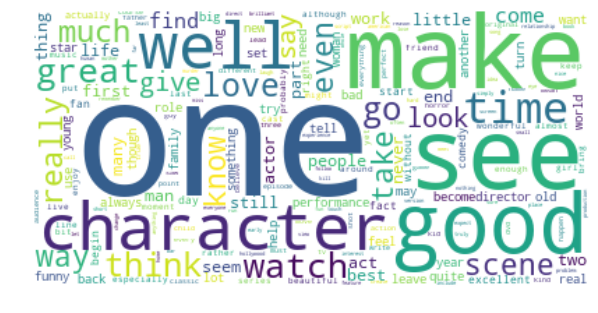

In [14]:
# Generate a word cloud image for positive reviews
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text_positive)

# Display the generated image, the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

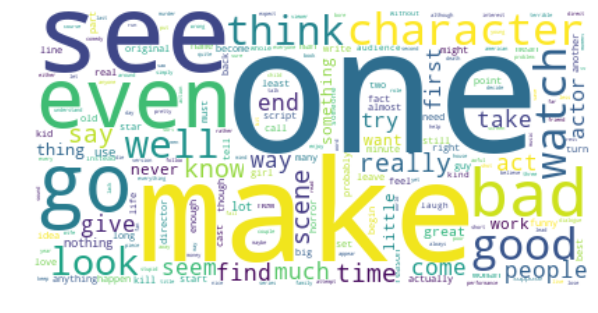

In [15]:
# Generate a word cloud image for positive reviews
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text_negative)

# Display the generated image, the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Observations :-

- **Words such as "good", "best", "great", "well", "love" are frequent in postive reviews.**

- **Words such as "bad", "nothing", "never" are frequent in negative reviews.**

<br>

### 2.2) Distribution of review lengths.

c:\users\smitr\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
c:\users\smitr\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'Token count')

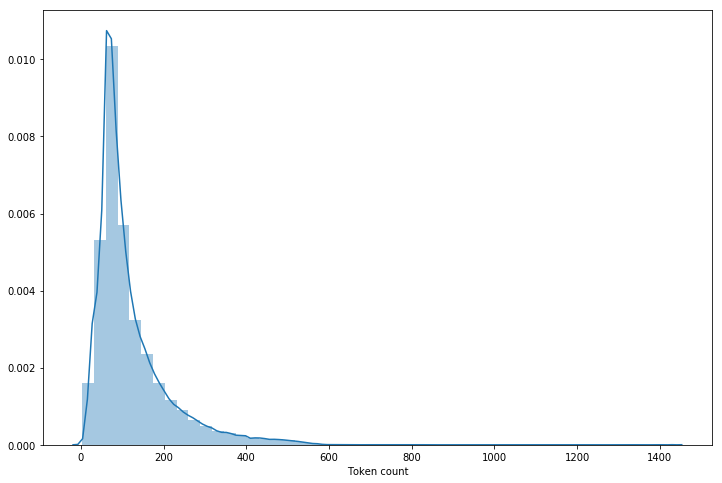

In [16]:
review_lengths = []

for review in df.review:
    review_lengths.append(len(review.split(" ")))

plt.figure(figsize=(12,8))
sns.distplot(review_lengths)
plt.xlabel('Token count')

<h3>Observation :-</h3>

**Review length distribution is similar to a Gaussian distribution that is right skewed.** 

<h3>Inference :-</h3>

**That means, the length of review with highest no.of words is going to be much much more than avg. review length.**

In [17]:
def find_review_length(review):
    """Returns length of review"""
    return len(review.split(" "))

In [18]:
df["review_len"] = df["review"].apply(find_review_length)
df.head()

,review,sentiment,review_len
0,one reviewer mention watch oz episode hook rig...,positive,170
1,wonderful little production film technique una...,positive,86
2,think wonderful way spend time hot summer week...,positive,87
3,basically family little boy jake think zombie ...,negative,63
4,petter matteis love time money visually stunni...,positive,127


In [20]:
print("Highest review length is : {}".format(max(df.review_len)))
print("Lowest review length is : {}".format(min(df.review_len)))
print("Average review length is : {}".format(sum(df.review_len)/df.shape[0]))

Highest review length is : 1431
Lowest review length is : 3
Average review length is : 120.04276


In [21]:
df.loc[df["review_len"] == 3]

,review,sentiment,review_len
31072,script story mess,negative,3


**Short & yet crisp review.**